$\gamma$ Ray Burst (GRB)

We have to explore the following data set and cluster the fast and slow GRB. Then, compare with the literature.

In [8]:
import requests
import numpy as np
import matplotlib.pyplot as plt

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)


['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


![Logo Python](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Ra_and_dec_on_celestial_sphere.png/330px-Ra_and_dec_on_celestial_sphere.png)


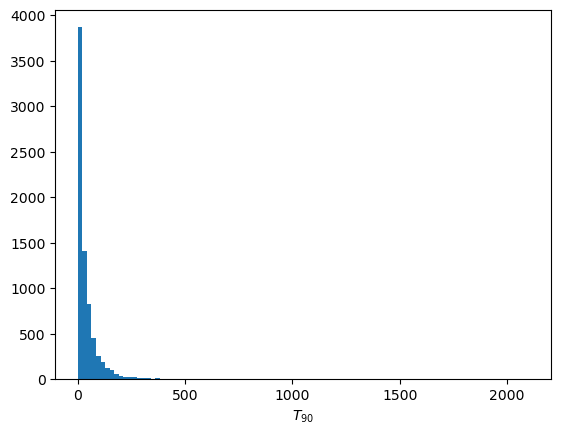

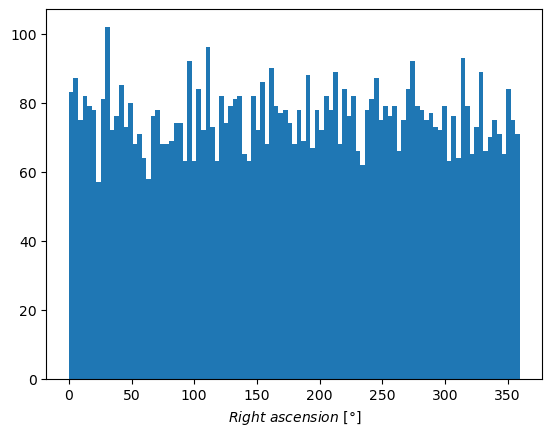

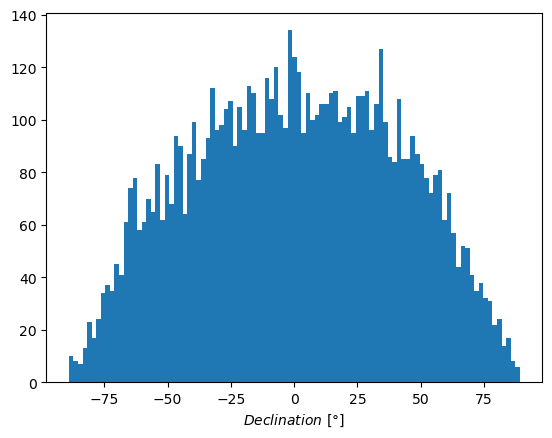

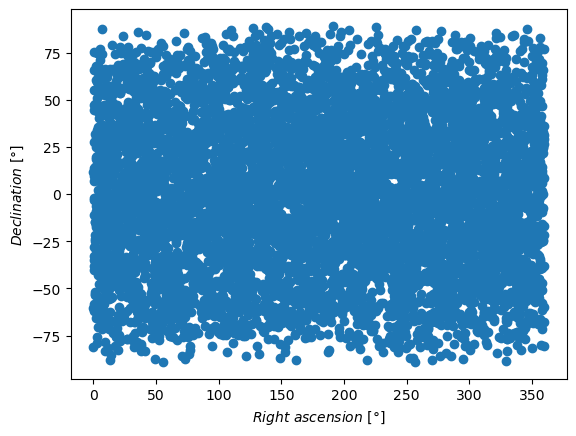

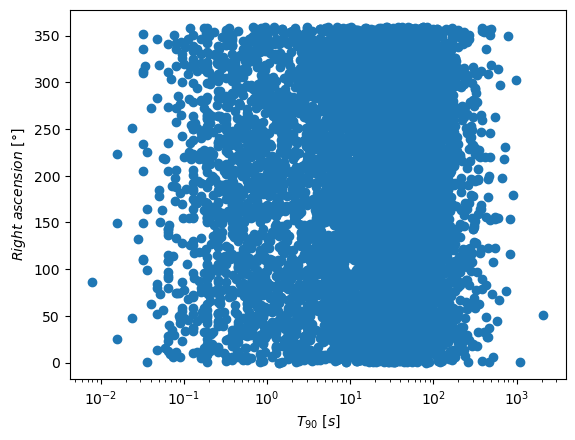

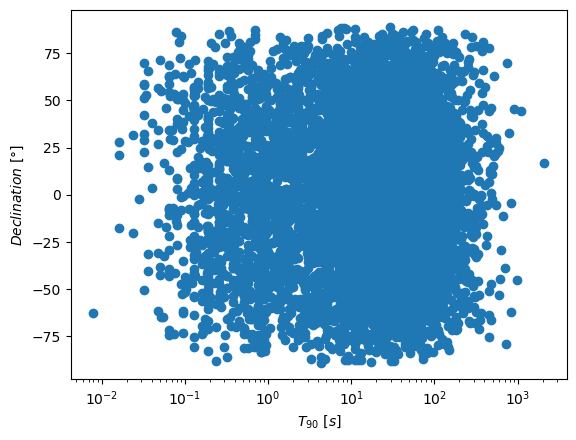

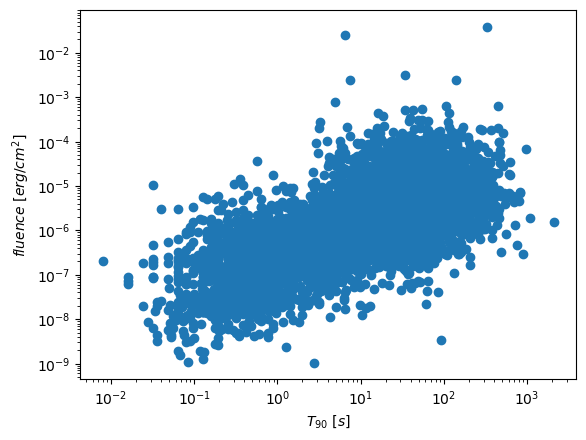

In [9]:
#fluence, unit: arg/cm^2, where 1 erg = 100 nJ
fluence = data[9] 
#T_90, unit: s
T90 = data[6]
#coord (see the image above)
ra = data[3] #Right ascension
decl = data[4] #Declination

T90 = np.array(T90, dtype=float)
fluence = np.array(fluence, dtype=float)
ra = np.array(ra, dtype=float)
decl = np.array(decl, dtype=float)


for i in range(len(T90)):
    if T90[i] == -999 or fluence[i] == -999 or ra[i]  == -999 or decl[i] == -999:
        T90[i] = -1000
        fluence[i] = -1000
        ra[i] = -1000
        decl[i] = -1000

T90 = T90[T90 != -1000]
fluence = fluence[fluence != -1000]
ra = ra[ra != -1000]
decl = decl[decl != -1000]


plt.hist(T90, bins=np.linspace(min(T90), max(T90), 100))
plt.xlabel('$T_{90}$')
plt.show()

plt.hist(ra, bins=np.linspace(min(ra), max(ra), 100))
plt.xlabel('$Right \ ascension \ [°]$')
plt.show()

plt.hist(decl, bins=np.linspace(min(decl), max(decl), 100))
plt.xlabel('$Declination \ [°]$')
plt.show()

plt.scatter(ra, decl)
plt.xlabel('$Right \ ascension \ [°]$')
plt.ylabel('$Declination \ [°]$')
plt.show()

plt.scatter(T90, ra)
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$Right \ ascension \ [°]$')
plt.xscale('log')
plt.show()

plt.scatter(T90, decl)
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$Declination \ [°]$')
plt.xscale('log')
plt.show()

plt.scatter(T90, fluence)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.show()

And now we are ready to cluster! 

First: K-Means Clustering. 

Here I use np.log10 because otherwise the algorithm does'n see the data in the same way I see it. In other words, the cluster I'm seeing are visible only in log scale.

[[ 1.52433303 -5.45840936]
 [ 0.05944233 -6.72009731]]


Text(0, 0.5, '$fluence \\ [erg/cm^2]$')

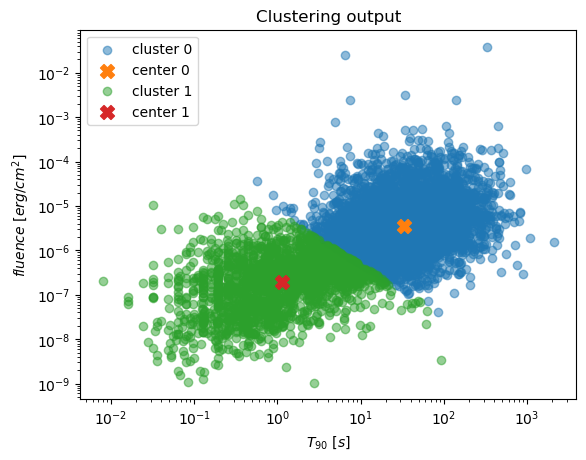

In [20]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_cluster = 2

#we need an array shape like [[x_1,y_1], ..., [x_n,y_n]]
X_old = np.vstack(( T90[(T90 != 0) & (fluence != 0)] ,  fluence[(fluence != 0) & (T90 != 0) ] )).T

X = np.vstack(( np.log10( T90[(T90 != 0) & (fluence != 0)] ), np.log10( fluence[(fluence != 0) & (T90 != 0) ] ) )).T

model = KMeans(n_clusters=n_cluster, n_init='auto').fit(X)
centers = model.cluster_centers_
labels = model.predict(X)

print(centers)

c = ['C0', 'C1', 'C2']
for i in range(n_cluster):
    plt.scatter(X_old[labels==i, 0], X_old[labels==i, 1], alpha=0.5, label=f'cluster {i}')
    plt.scatter(10**(centers[i,0]), 10**(centers[i,1]), label=f'center {i}', marker='X', s=100)
    plt.xscale('log')
    plt.yscale('log')

plt.title('Clustering output')
plt.legend()
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')


(100.0, 200.0)

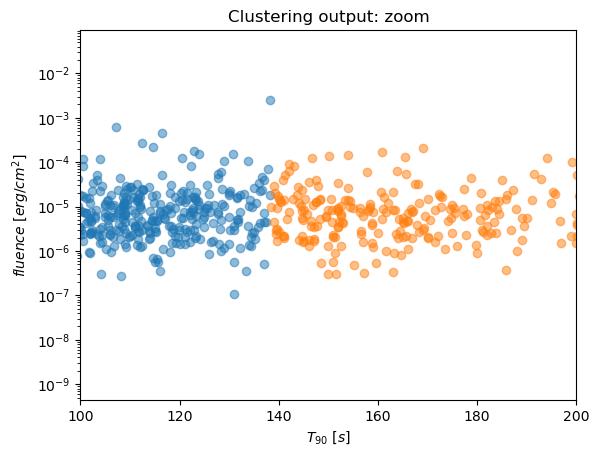

In [ ]:
for ii in range(n_cluster):
    plt.scatter(X[labels==ii,0], X[labels==ii,1] ,alpha=0.5)
    #plt.xscale('log')
    plt.yscale('log')

plt.title('Clustering output: zoom')
plt.xlabel('$T_{90} \ [s]$')
plt.ylabel('$fluence \ [erg/cm^2]$')
plt.xlim([100,200])

Second: Mean-shift Clustering

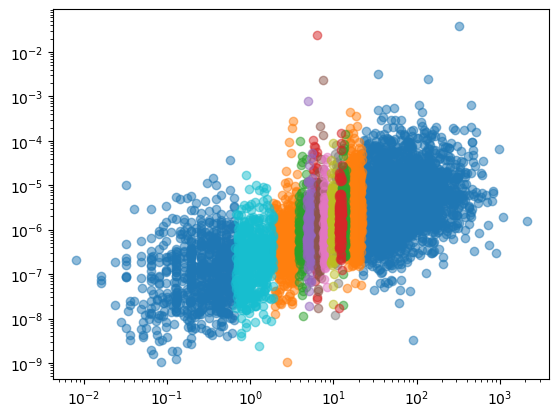

In [ ]:
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

labels = ms.predict(X)


for ii in range(max(labels)):
    plt.scatter(X[labels==ii,0], X[labels==ii,1],alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')